In [121]:
import pandas as pd
import matplotlib.pyplot as plt
import scienceplots 
plt.style.use(['science','no-latex'])

import os
notebook_abs_path = os.path.abspath(os.getcwd())
REPO_ROOT = os.path.join(notebook_abs_path, os.pardir, os.pardir)

import sys
sys.path.append(REPO_ROOT)

from nebula.misc.plots import set_size

def read_metrics_file(metrics_file_fullpath):
    metrics = pd.read_csv(metrics_file_fullpath)
    return metrics

def walk_training_folder(training_folder, metric, skip=[]):
    output_df = pd.DataFrame() # should have structure: index => steps; columns => number of families; values => metric
    for root, subdirs, files in os.walk(training_folder):
        for subdir in subdirs:
            if 'nr_families' in subdir and subdir.endswith('csv'):
                nr_of_families = int(subdir.split('nr_families_')[1].split('_')[0])
                model = subdir.split('_')[0]
                if model in skip:
                    continue
                metrics_file_fullpath = os.path.join(training_folder, subdir, "version_0", "metrics.csv")
                if os.path.exists(metrics_file_fullpath):
                    metrics = read_metrics_file(metrics_file_fullpath)
                else:
                    metrics = pd.DataFrame()
                output_df[nr_of_families] = metrics[metric]
    # order columns by number of families
    output_df = output_df.reindex(sorted(output_df.columns), axis=1)
    return model, output_df
                
def read_stats(outfolder, metric, skip=[], training_prefix="training"):
    # metrics val_loss,val_f1,val_tpr,val_acc,val_auc,val_recall,val_precision,train_f1,train_tpr,train_acc,train_auc,train_recall,train_precision
    results = {}
    # results will have structure: index => nr of families; columns => model type; values => metric
    for root, dirs, files in os.walk(outfolder):
        for d in dirs:
            if not d.startswith(training_prefix):
                continue
            training_folder = os.path.join(outfolder, d)
            model, model_metric_df = walk_training_folder(training_folder, metric, skip)
            results[model] = model_metric_df
    return results

def carve_out_stat(results, how='last'):
    assert how in ['last', 'best']
    output = pd.DataFrame()

    for model in results.keys():
        for col in results[model].columns:
            # print(col, results['nebulabpe'][col].dropna().shape)
            try:
                if how == 'best':
                    last_val = results[model][col].dropna().values.max()
                elif how == 'last':
                    last_val = results[model][col].dropna().values[-1]
                output.at[model, col] = last_val
            except:
                pass
                
    return output



def line_scatter_plot_stat(stat_df, skip=[], ax=None, linestyle="--", marker='o', tab_colors = ['tab:blue', 'tab:orange', 'tab:green']) -> plt.Axes:
    if ax is None:
        fig, ax = plt.subplots(figsize=(8,6))
    
    for i, model in enumerate(stat_df.T.columns):
        if model in skip:
            continue
        ax.plot(stat_df.T.index, stat_df.T[model], linestyle=linestyle, marker=marker, label=model, color=tab_colors[i])

    return ax

In [122]:
# speakeasy
outfolder = 'out_family_downscale_speakeasy_PROD'

results = read_stats(outfolder, 'val_acc', skip=['dmds'], training_prefix="ordered")
speakeasy_stat_df = carve_out_stat(results, how='best')

# avast
outfolder = 'out_family_downscale_avast_PROD'

results = read_stats(outfolder, 'val_f1', skip=[], training_prefix="training_")
avast_stat_df = carve_out_stat(results, how='best')

# order index in avast as in speakeasy
avast_stat_df = avast_stat_df.reindex(speakeasy_stat_df.index)


In [123]:
avast_stat_df

,3,4,5,6,7,8,9,10
nebulawht,0.990936,0.931657,0.871326,0.885501,0.882261,0.881100,0.898173,0.812482
nebulabpe,0.983935,0.915005,0.869173,0.900600,0.869274,0.903089,0.902086,0.813340
neurlux,0.993344,0.945289,0.926266,0.930289,0.914178,0.927145,0.907507,0.892857


In [124]:
speakeasy_stat_df

,3,4,5,6,7,8
nebulawht,0.846631,0.755829,0.641910,0.593023,0.504553,0.547696
nebulabpe,0.873376,0.786441,0.751010,0.535869,0.489063,0.495778
neurlux,0.662418,0.607653,0.538772,0.496773,0.489063,0.459815


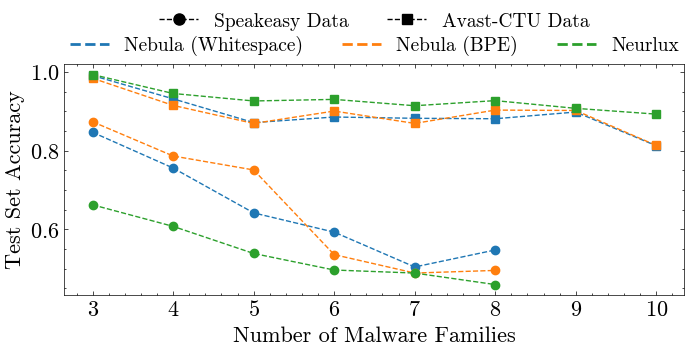

In [137]:
fig,ax = plt.subplots(figsize=(8, 3))

markers = ['o', 's', 'v', 'D', 'X', 'P']
ax = line_scatter_plot_stat(speakeasy_stat_df, ax=ax, marker="o")
ax = line_scatter_plot_stat(avast_stat_df, ax=ax, linestyle="--", marker="s")

handles, labels = ax.get_legend_handles_labels()
labels_1 = [
    'Nebula (Whitespace)',
    'Nebula (BPE)',
    'Neurlux',
]

tab_colors = ['tab:blue', 'tab:orange', 'tab:green']
handles_1 = []
for color in tab_colors:
    handles_1.append(plt.Line2D([0], [0], color=color, lw=2, linestyle='--'))

labels_2 = [
    'Speakeasy Data',
    'Avast-CTU Data'
]
handles_2 = []
handles_2.append(plt.Line2D([0], [0], color='black', linestyle='--', marker='o', markersize=8))
handles_2.append(plt.Line2D([0], [0], color='black', linestyle='--', marker='s', markersize=7))

legend_1 = ax.legend(
    loc='upper center',
    bbox_to_anchor=(0.5, 1.20),
    fontsize=14,
    labels=labels_1,
    handles=handles_1,
    ncol=3
)

# add second legend to the same plot
legend_2 = ax.legend(
    loc='upper center',
    # loc=1,
    bbox_to_anchor=(0.5, 1.3),
    fontsize=14,
    labels=labels_2,
    handles=handles_2,
    ncol=2
)
ax.add_artist(legend_1)

ax.set_xlabel('Number of Malware Families', fontsize=16)
ax.set_ylabel('Test Set Accuracy', fontsize=16)

# increase size of xtickslabels and ytickslabels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

fig.savefig(os.path.join('img', 'family_downscale_together.pdf'), dpi=300, bbox_inches='tight')

# Speakeasy Run

,3,4,5,6,7,8
nebulawht,0.846631,0.755829,0.641910,0.593023,0.504553,0.547696
nebulabpe,0.873376,0.786441,0.751010,0.535869,0.489063,0.495778
neurlux,0.662418,0.607653,0.538772,0.496773,0.489063,0.459815


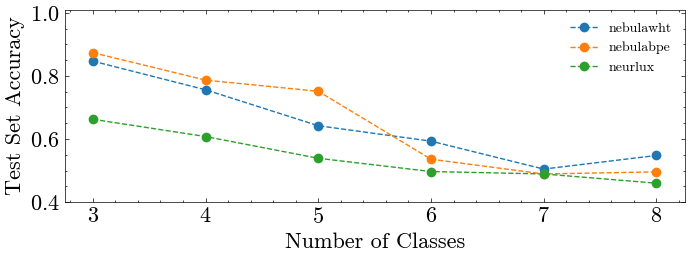

In [51]:
outfolder = 'out_family_downscale_speakeasy_PROD'
fig, ax = plt.subplots(figsize=(8, 2.5))

results = read_stats(outfolder, 'val_acc', skip=['dmds'], training_prefix="ordered")
stat_df = carve_out_stat(results, how='best')
ax = line_scatter_plot_stat(stat_df, ax=ax)

# ax.set_ylim(0.4, 0.95)
handles, labels = ax.get_legend_handles_labels()
labels_new = [
    'Nebula (Whitespace tokenizer)',
    'Nebula (BPE tokenizer)',
    'Neurlux'
]
# ax.legend(
#     loc='upper right',
#     fontsize=14,
#     labels=labels_new,#[::-1],
#     handles=handles,#[::-1]
# )
# ax.legend([], [])

ax.set_ylim(0.4,1.01)

ax.set_xlabel('Number of Classes', fontsize=16)
ax.set_ylabel('Test Set Accuracy', fontsize=16)

# increase size of xtickslabels and ytickslabels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)

stat_df

# fig = ax.get_figure()
fig.savefig(os.path.join('img', 'family_downscale_speakeasy.pdf'), dpi=300, bbox_inches='tight')

stat_df

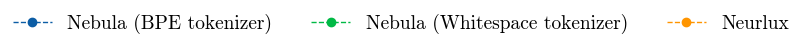

In [62]:
fig, ax = plt.subplots(figsize=(8, 0.5))
ax.legend(
    handles=handles,
    labels=labels_new,
    ncol=3,
    # center legend
    loc='center',
    fontsize=14
)
ax.axis('off')
# savefig as pdf
fig.savefig(os.path.join('img', 'family_downscale_speakeasy_legend.pdf'), dpi=300, bbox_inches='tight')


# Avast-CTU Data Run

,3,4,5,6,7,8,9,10
neurlux,0.993344,0.945289,0.926266,0.930289,0.914178,0.927145,0.907507,0.892857
nebulawht,0.990936,0.931657,0.871326,0.885501,0.882261,0.881100,0.898173,0.812482
nebulabpe,0.983935,0.915005,0.869173,0.900600,0.869274,0.903089,0.902086,0.813340


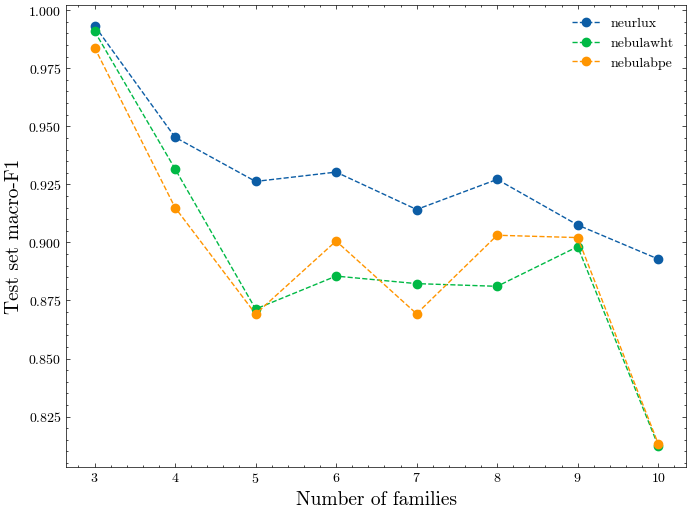

In [55]:
outfolder = 'out_family_downscale_avast_PROD'
results = read_stats(outfolder, 'val_f1', skip=[], training_prefix="training_")
stat_df = carve_out_stat(results, how='best')
ax = line_scatter_plot_stat(stat_df)

ax.set_xlabel('Number of families', fontsize=14)
ax.set_ylabel('Test set macro-F1', fontsize=14)
stat_df

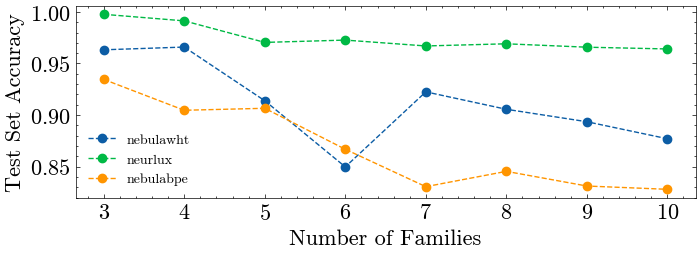

In [15]:
outfolder = 'out_family_downscale_avast_PROD'
fig,ax = plt.subplots(figsize=(8, 2.5))

results = read_stats(outfolder, 'val_acc', skip=[], training_prefix="training_r33")
stat_df = carve_out_stat(results, how='best')

# reshuflle index -- nebulawht_dropout0.3, then nebulabpe_dropout0.3, then neurlux
# stat_df = stat_df.reindex(['nebulawht_dropout0.3', 'nebulabpe_dropout0.3', 'neurlux'])

ax = line_scatter_plot_stat(stat_df, ax=ax)

# ax.set_ylim(0.85, 1.01)
# handles, labels = ax.get_legend_handles_labels()
# labels_new = [
#     'Nebula (BPE tokenizer)',
#     'Nebula (Whitespace tokenizer)',
#     'Neurlux'
# ]
# ax.legend(
#     loc='lower left',
#     fontsize=14,
#     labels=labels_new[::-1],
#     handles=handles[::-1]
# )
# ax.legend([], [])

# ax.set_ylim(0.4, 1.05)

ax.set_xlabel('Number of Families', fontsize=16)
ax.set_ylabel('Test Set Accuracy', fontsize=16)
# increase size of xtickslabels and ytickslabels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
stat_df

# fig = ax.get_figure()
fig.savefig(os.path.join('img', 'family_downscale_avast.pdf'), dpi=300, bbox_inches='tight')

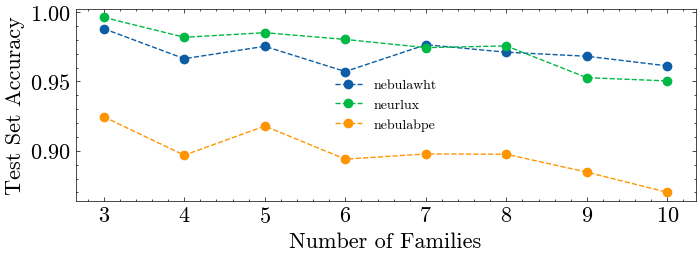

In [17]:
outfolder = 'out_family_downscale_avast_PROD'
fig,ax = plt.subplots(figsize=(8, 2.5))

results = read_stats(outfolder, 'train_acc', skip=[], training_prefix="training_r33")
stat_df = carve_out_stat(results, how='best')

# reshuflle index -- nebulawht_dropout0.3, then nebulabpe_dropout0.3, then neurlux
# stat_df = stat_df.reindex(['nebulawht_dropout0.3', 'nebulabpe_dropout0.3', 'neurlux'])

ax = line_scatter_plot_stat(stat_df, ax=ax)

# ax.set_ylim(0.85, 1.01)
# handles, labels = ax.get_legend_handles_labels()
# labels_new = [
#     'Nebula (BPE tokenizer)',
#     'Nebula (Whitespace tokenizer)',
#     'Neurlux'
# ]
# ax.legend(
#     loc='lower left',
#     fontsize=14,
#     labels=labels_new[::-1],
#     handles=handles[::-1]
# )
# ax.legend([], [])

# ax.set_ylim(0.4, 1.05)

ax.set_xlabel('Number of Families', fontsize=16)
ax.set_ylabel('Test Set Accuracy', fontsize=16)
# increase size of xtickslabels and ytickslabels
ax.tick_params(axis='both', which='major', labelsize=16)
ax.tick_params(axis='both', which='minor', labelsize=16)
stat_df

# fig = ax.get_figure()
fig.savefig(os.path.join('img', 'family_downscale_avast.pdf'), dpi=300, bbox_inches='tight')